In [1]:
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# !pip install ipython
# !pip install Pillow

In [2]:
# # Cek GPU

# # Cek ketersediaan GPU
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     print("GPU tersedia:", gpus)
# else:
#     print("GPU tidak tersedia.")

# # Cek perangkat yang sedang digunakan
# device_name = tf.test.gpu_device_name()
# if device_name:
#     print(f"TensorFlow menggunakan GPU: {device_name}")
# else:
#     print("TensorFlow tidak menggunakan GPU.")

In [3]:
# print("Versi TensorFlow:", tf.__version__)
# cuda_version = tf.sysconfig.get_build_info().get("cuda_version", "Tidak tersedia")
# cudnn_version = tf.sysconfig.get_build_info().get("cudnn_version", "Tidak tersedia")

# print(f"Versi CUDA: {cuda_version}")
# print(f"Versi cuDNN: {cudnn_version}")

In [4]:
# from tensorflow.python.client import device_lib

# print("Perangkat yang terdeteksi:")
# print(device_lib.list_local_devices())

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

2024-11-18 23:50:47.141055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 23:50:47.278769: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 23:50:47.306299: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 23:50:47.812155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

### iterate through the folders to create a dataframe of the form filepaths labels

In [6]:
sdir=r'./Gym Equipment Output'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths       labels
0  ./Gym Equipment Output/Bench Press/61cGWhpz3ZL...  Bench Press
1  ./Gym Equipment Output/Bench Press/bench-press...  Bench Press
2  ./Gym Equipment Output/Bench Press/benchPress_...  Bench Press
3  ./Gym Equipment Output/Bench Press/benchPress_...  Bench Press
4  ./Gym Equipment Output/Bench Press/benchPress_...  Bench Press
labels
Dumbells              667
Bench Press           136
Recumbent Bike         83
Elliptical Machine     77
Treadmill              63
Smith Machine          31
Name: count, dtype: int64


### split df into train_df, test_df and valid_df

In [7]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  845   test_df length:  106   valid_df length:  106


### create train, test, valid  generators

In [8]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  53   test steps:  2
Found 845 validated image filenames belonging to 6 classes.
Found 106 validated image filenames belonging to 6 classes.
Found 106 validated image filenames belonging to 6 classes.
['Bench Press', 'Dumbells', 'Elliptical Machine', 'Recumbent Bike', 'Smith Machine', 'Treadmill']


### create function to show some image examples

In [9]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

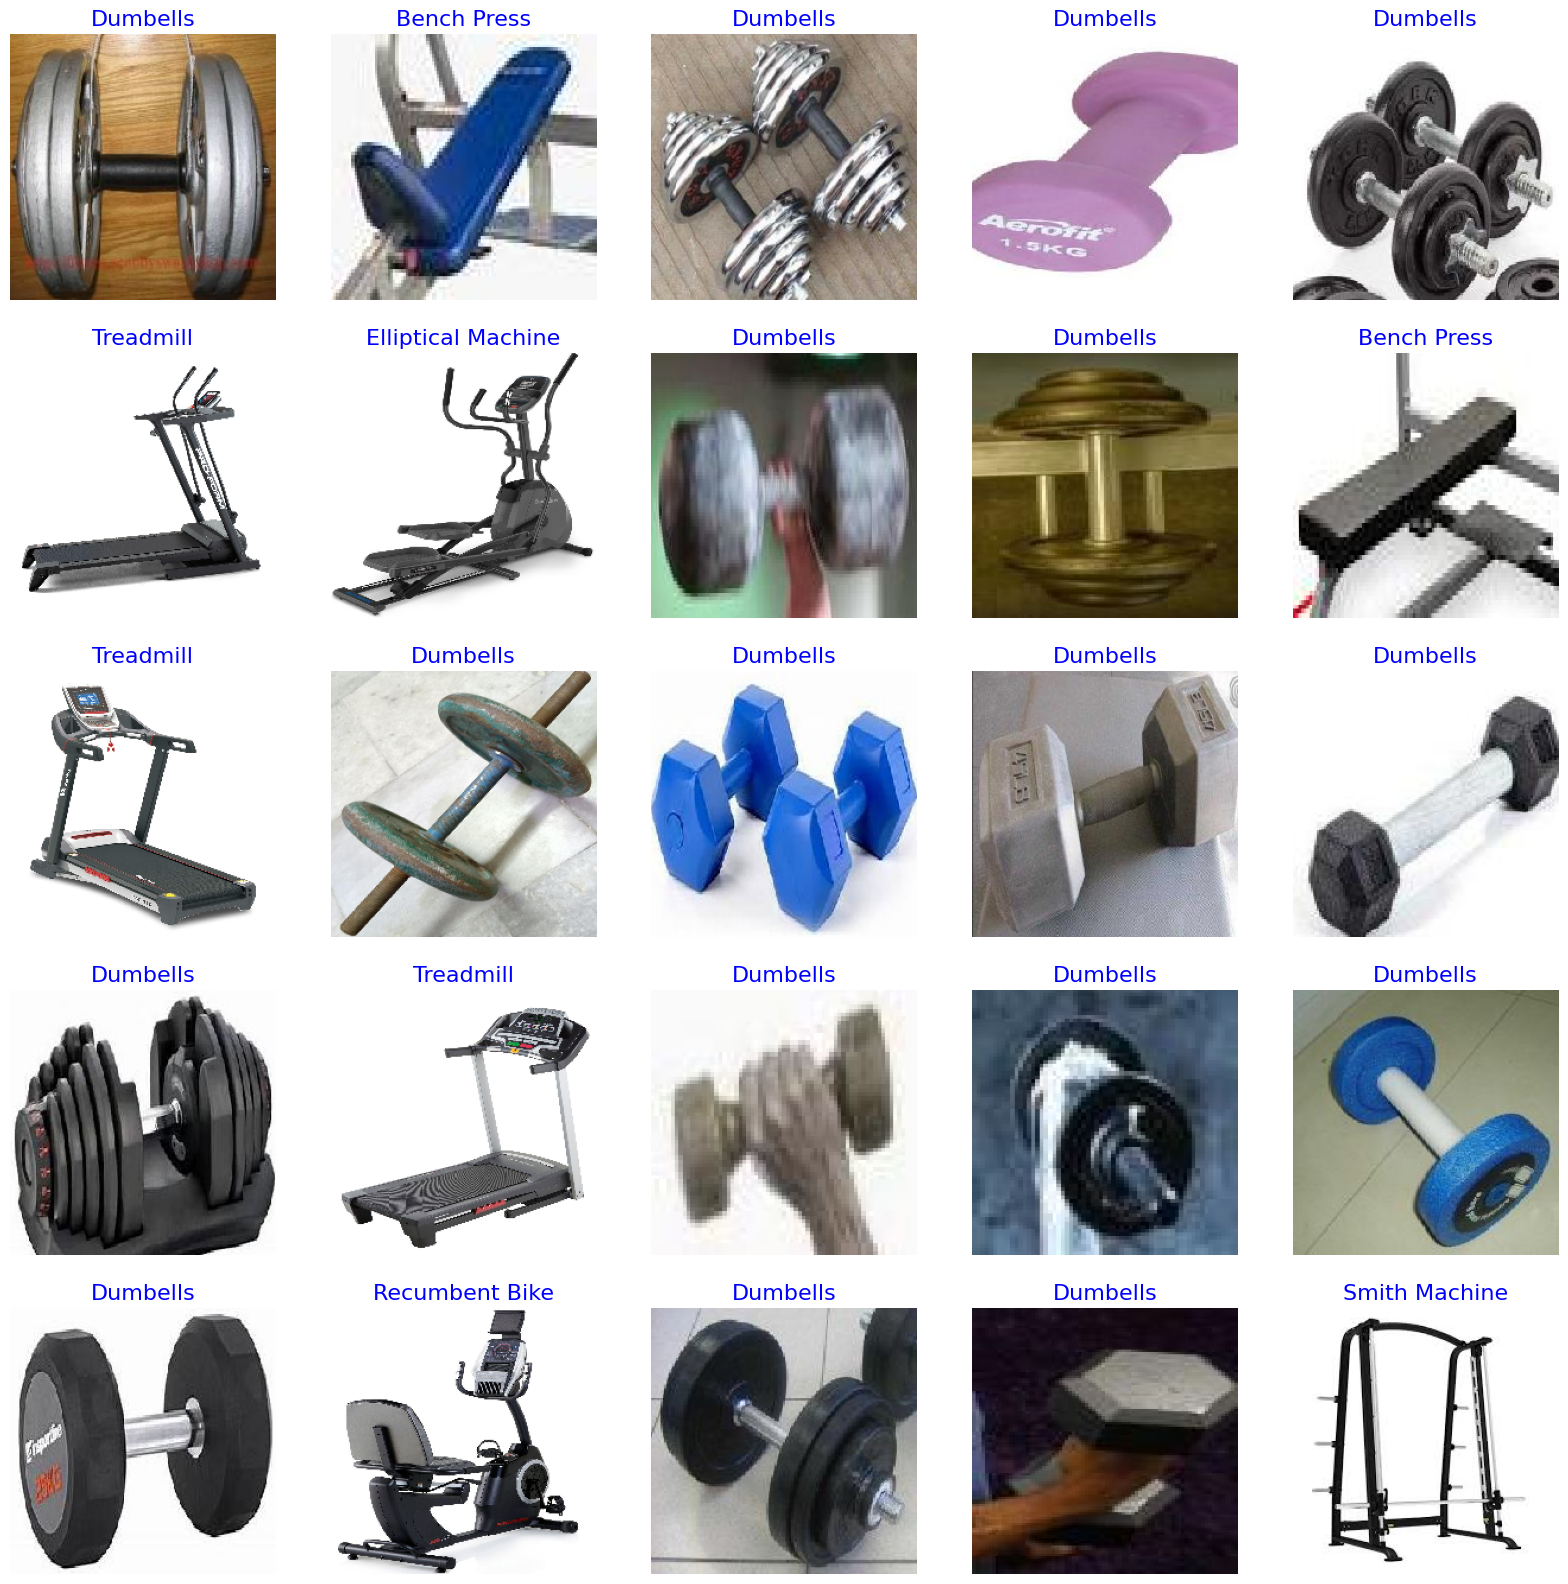

In [10]:
show_image_samples(train_gen)

### create the model

In [11]:
base_model=tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3))) 

2024-11-18 23:50:51.916505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-18 23:50:51.924457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-18 23:50:51.924502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-18 23:50:51.925683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [13]:
base_model.trainable = False

In [14]:
model_name='GymLens'
print("Building model with", base_model)
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=(1, 1), strides=(1, 1)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(class_count, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.engine.functional.Functional object at 0x7f9f57f00af0>


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          368672    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                        

In [16]:
epochs =20

history=model.fit(x=train_gen, batch_size=64, epochs=epochs, validation_data=valid_gen)

Epoch 1/20


/home/portia/miniconda3/envs/tf/lib/python3.9/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
2024-11-18 23:50:56.730731: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-11-18 23:50:57.674616: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-18 23:50:57.727065: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-18 23:50:57.727193: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-11-18 23:50:57.771038: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-18 23:50:57.771177: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch p

14/14 [==============================] - 12s 545ms/step - loss: 0.8801 - accuracy: 0.6391 - val_loss: 0.4601 - val_accuracy: 0.8396
Epoch 2/20
14/14 [==============================] - 4s 298ms/step - loss: 0.3022 - accuracy: 0.8710 - val_loss: 0.2662 - val_accuracy: 0.9151
Epoch 3/20
14/14 [==============================] - 4s 315ms/step - loss: 0.1597 - accuracy: 0.9373 - val_loss: 0.2359 - val_accuracy: 0.9151
Epoch 4/20
14/14 [==============================] - 4s 295ms/step - loss: 0.0924 - accuracy: 0.9645 - val_loss: 0.1703 - val_accuracy: 0.9434
Epoch 5/20
14/14 [==============================] - 4s 313ms/step - loss: 0.0508 - accuracy: 0.9858 - val_loss: 0.2721 - val_accuracy: 0.9434
Epoch 6/20
14/14 [==============================] - 4s 300ms/step - loss: 0.0225 - accuracy: 0.9953 - val_loss: 0.2052 - val_accuracy: 0.9623
Epoch 7/20
14/14 [==============================] - 4s 295ms/step - loss: 0.0082 - accuracy: 0.9953 - val_loss: 0.2734 - val_accuracy: 0.9528
Epoch 8/20
14/14

### define function to print text in RGB foreground and background colors

In [17]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

### define function to plot the training data

In [18]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### define function to generate the confusion matrix and classification report

In [19]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### evaluate model on the test set then save the model

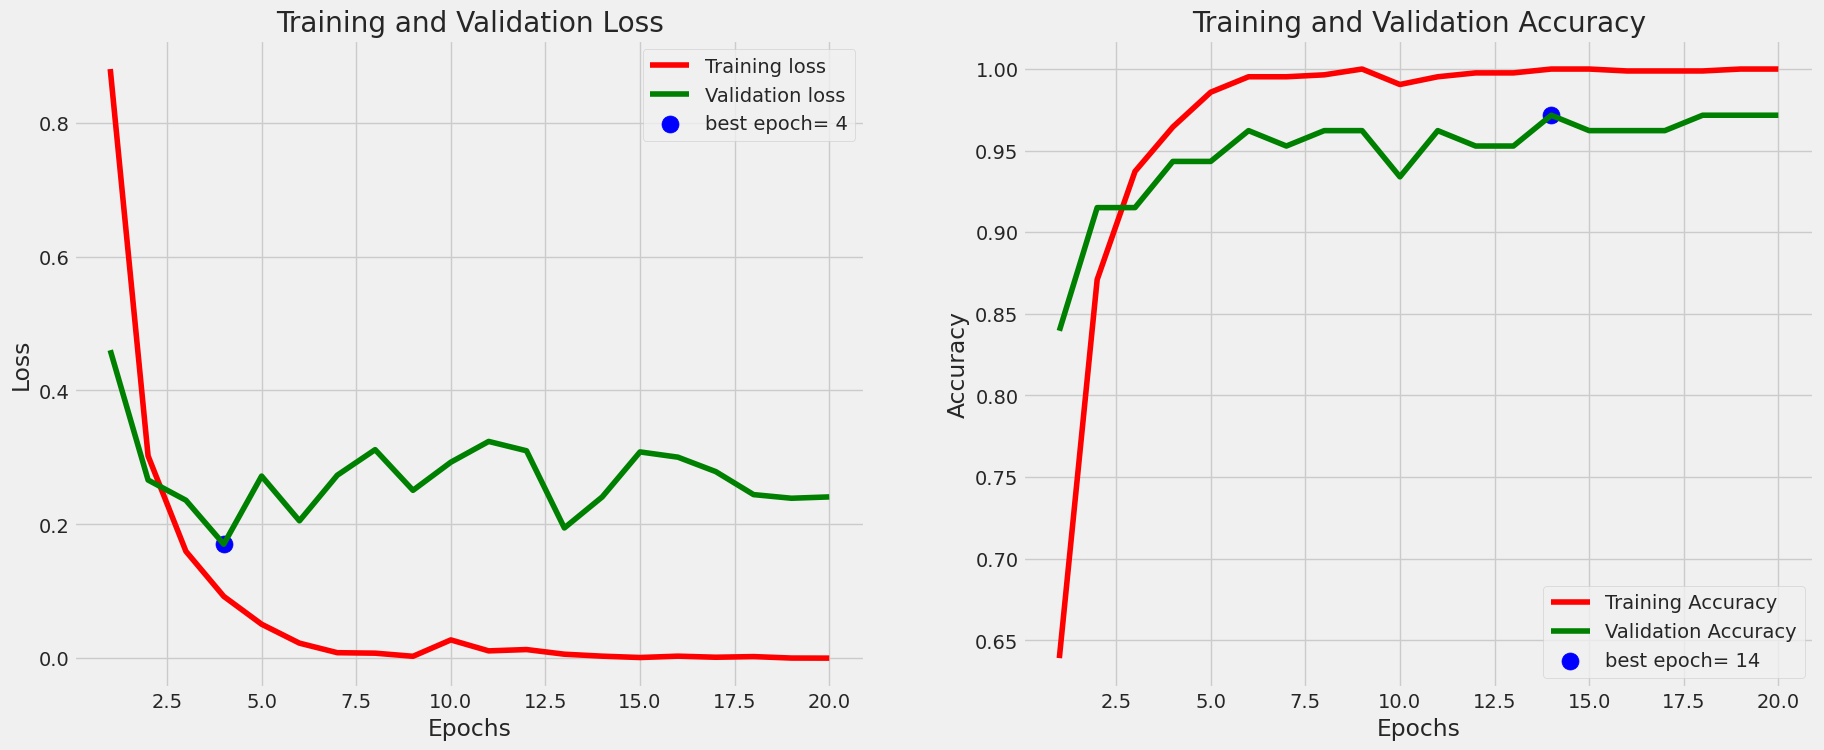

2/2 [==============================] - 1s 185ms/step - loss: 0.0125 - accuracy: 1.0000
accuracy on the test set is 100.00 %



In [20]:
tr_plot(history,0)
save_dir=r'./'
subject='Gym Exception'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

### make predictions on test set and generate confusion matrix and classification report

2/2 [==============================] - 1s 177ms/step


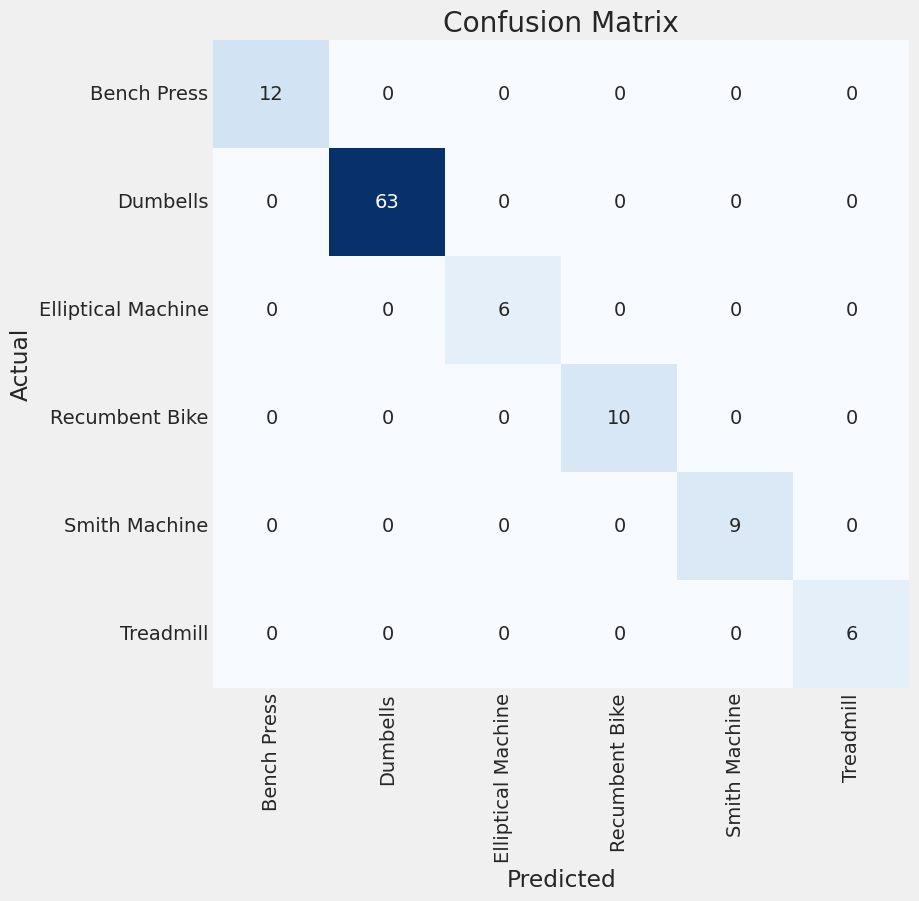

Classification Report:
----------------------
                     precision    recall  f1-score   support

       Bench Press       1.00      1.00      1.00        12
          Dumbells       1.00      1.00      1.00        63
Elliptical Machine       1.00      1.00      1.00         6
    Recumbent Bike       1.00      1.00      1.00        10
     Smith Machine       1.00      1.00      1.00         9
         Treadmill       1.00      1.00      1.00         6

          accuracy                           1.00       106
         macro avg       1.00      1.00      1.00       106
      weighted avg       1.00      1.00      1.00       106



In [21]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

In [22]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# import numpy as np

# height=224
# width=224

# Assuming 'model' is already loaded
def file_predict(folder_path, out):
    """A function for creating predictions for all images in a specified folder."""
    # Define the class names
    classes = ["Bench Press", "Dumbells", "Eliptical", "Recumbent Bike", "Smith Machine", "treadmill"]
    
    # Loop through each file in the folder
    for filename in os.listdir(folder_path):
        # Construct full file path
        file_path = os.path.join(folder_path, filename)
        
        # Check if the file is an image (optional extension filter)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                # Load and preprocess the image
                image = load_img(file_path, target_size=(224, 224))
                image = img_to_array(image)
                image = np.expand_dims(image, axis=0)  # Expand dimensions to match model input
                
                # Predict the class probabilities
                prediction = model.predict(image, verbose=0)[0]
                
                # Print the model's raw output
                print(f'\nModel output (probabilities) for {filename}: {prediction}')
                
                # Find the index of the highest probability
                prediction_index = np.argmax(prediction)
                
                # Get the predicted class name
                predicted_class = classes[prediction_index]
                
                # Print the result
                print(f'{filename} is predicted to be: {predicted_class}')
            
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
        else:
            print(f'Skipping non-image file: {filename}')

# Example usage
folder_path = 'test/'  # Replace with your folder path
file_predict(folder_path, 'out')



Model output (probabilities) for benchpress.png: [5.6451989e-13 1.0000000e+00 1.5569289e-14 1.9769258e-12 2.5304442e-14
 3.1134746e-13]
benchpress.png is predicted to be: Dumbells

Model output (probabilities) for bp2.png: [5.6164889e-10 1.0000000e+00 1.0549931e-10 5.0022547e-10 1.5777413e-10
 3.0262876e-10]
bp2.png is predicted to be: Dumbells

Model output (probabilities) for bp3.png: [2.65826028e-09 1.00000000e+00 1.16093746e-10 9.22656795e-09
 2.76805606e-10 5.29482347e-10]
bp3.png is predicted to be: Dumbells

Model output (probabilities) for bp4.png: [3.2858063e-10 1.0000000e+00 3.3834342e-11 8.4461077e-10 5.6591763e-11
 4.4289294e-10]
bp4.png is predicted to be: Dumbells

Model output (probabilities) for bp5.png: [1.3626459e-13 1.0000000e+00 1.5322472e-14 5.7452318e-13 1.5706822e-14
 2.2961177e-13]
bp5.png is predicted to be: Dumbells

Model output (probabilities) for bp6.png: [7.0932513e-09 1.0000000e+00 8.4361740e-10 1.4305605e-08 1.7320441e-09
 4.4914841e-09]
bp6.png is pred